In [2]:
# Import libraries
#!pip install opencv-python
import os,cv2
import numpy as np
import tensorflow
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
K.image_data_format() == 'th'

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
import glob

# Data Reading and Labeling

In [3]:
PATH = os.getcwd()
# Define data path
data_path = 'D:/My Documents New/DL ML BC CC/Dice Analytics/Assignment/Project 1/OCT_Dataset'
 
data_dir_list = os.listdir(data_path)

img_rows=128
img_cols=128
num_channel=1
num_epoch=2
no_images=0

for dataset in data_dir_list:
    img_list = os.listdir(data_path + '/' + dataset)
    no_images = no_images+len(img_list)

# Define the number of classes
labels = np.ones((no_images,),dtype='int64')
num_classes = 3
label_index=0
img_data_list=[]
img=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    #print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img)
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        if dataset[0]==  'A':
            labels[label_index]=  0
            #print(dataset[0])
        if dataset[0] == 'D':
            labels[label_index] = 1
            #print(dataset[0])
        if dataset[0] == 'N':
            labels[label_index] = 2
        label_index = label_index+1
            #print(dataset[0])


# Preprocessing steps

In [4]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data /= 255
print (img_data.shape)


# Using 'th' for the image_dim_ordering we get accuracy >=0.99 . 
# Using 'tf' for the dim order I get accuracy >= 0.9 but on more epochs
if num_channel==1:
    if K.image_data_format()=='th':
        img_data= np.expand_dims(img_data, axis=1)
        print (img_data.shape)
    else:
        img_data= np.expand_dims(img_data, axis=-1)
        print (img_data.shape)

else:
    if K.image_data_format()=='th':
        img_data=np.rollaxis(img_data,3,1)
        print (img_data.shape)


        labels[0:722] = 0
        labels[723:1823] = 1
        labels[1824:3231] = 2
        
 #---->

USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
    # using sklearn for preprocessing
    from sklearn import preprocessing

    def image_to_feature_vector(image, size=(128, 128)):
        # resize the image to a fixed size, then flatten the image into
        # a list of raw pixel intensities
        return cv2.resize(image, size).flatten()

    img_data_list=[]
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
            input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_flatten=image_to_feature_vector(input_img,(128,128))
            img_data_list.append(input_img_flatten)

    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    print (img_data.shape)
    img_data_scaled = preprocessing.scale(img_data)
    print (img_data_scaled.shape)

    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)


    if K.image_dim_ordering()=='th':
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
        print (img_data_scaled.shape)

    else:
        img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
        print (img_data_scaled.shape)

if USE_SKLEARN_PREPROCESSING:
    img_data=img_data_scaled
    
    #%%
#labels[0:1000]
#%%



(3231, 128, 128)
(3231, 128, 128, 1)


In [5]:
# Assigning Labels

# Define the number of classes

from tensorflow.keras.utils import to_categorical

num_classes = 3

names = ['AMD','DME','NORMAL']

# convert class labels to on-hot encoding
Y = to_categorical(labels, num_classes)

#Shuffle the dataset with random state=2
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset with 20% testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [6]:
X_test.shape

(647, 128, 128, 1)

In [7]:
X_train.shape

(2584, 128, 128, 1)

In [8]:
print(Y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Define the model 

In [9]:
# Defining the model 
# Feel free to use CNNs/Dense Networks
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
#from keras.layers.normalization import LayerNormalization
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(128, 128, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.AveragePooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.AveragePooling2D((2, 2)))


model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))

model.add(layers.Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization(momentum=0.99, epsilon=0.01))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

# Viewing model_configuration
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0

In [10]:
learning_rate = 0.0001
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['acc'])

Epoch 1/60
65/65 - 57s - loss: 1.5465 - acc: 0.4504 - val_loss: 1.5576 - val_acc: 0.2224
Epoch 2/60
65/65 - 54s - loss: 1.2989 - acc: 0.5728 - val_loss: 1.6310 - val_acc: 0.2224
Epoch 3/60
65/65 - 69s - loss: 1.1383 - acc: 0.6604 - val_loss: 1.6910 - val_acc: 0.2224
Epoch 4/60
65/65 - 66s - loss: 1.0727 - acc: 0.7039 - val_loss: 1.7228 - val_acc: 0.2224
Epoch 5/60
65/65 - 62s - loss: 1.0100 - acc: 0.7407 - val_loss: 1.6509 - val_acc: 0.2398
Epoch 6/60
65/65 - 56s - loss: 0.9465 - acc: 0.7847 - val_loss: 1.5971 - val_acc: 0.2766
Epoch 7/60
65/65 - 62s - loss: 0.9271 - acc: 0.8045 - val_loss: 1.3624 - val_acc: 0.5474
Epoch 8/60
65/65 - 58s - loss: 0.8852 - acc: 0.8297 - val_loss: 1.2457 - val_acc: 0.5474
Epoch 9/60
65/65 - 61s - loss: 0.8362 - acc: 0.8568 - val_loss: 0.9323 - val_acc: 0.7621
Epoch 10/60
65/65 - 60s - loss: 0.8067 - acc: 0.8670 - val_loss: 0.9456 - val_acc: 0.7079
Epoch 11/60
65/65 - 62s - loss: 0.7746 - acc: 0.8834 - val_loss: 0.6924 - val_acc: 0.9787
Epoch 12/60
65/65 -

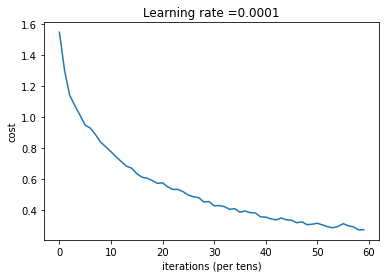



Accuracy on training set is 0.988872766494751
Saved model to disk
Loaded model from disk


In [11]:
# Train and fit wit appropiate batch size, epochs, verbose = 1 and validation set

no_epochs = 60
batch_size = 32

history = model.fit(X_train, y_train,
            batch_size = batch_size,
            epochs = no_epochs,
            verbose= 2,
            validation_split = 0.2)
    
plt.plot(np.squeeze(history.history["loss"]))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()
    
print("\n\nAccuracy on training set is {}".format(history.history["acc"][-1]))


# model saving 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# Save the model in hdf5 file
model.save("saved_models/AMD_DME_Normal.hdf5")

# Load the saved model
loaded_model= load_model("saved_models/AMD_DME_Normal.hdf5")

In [12]:
# Evaluate the model w.r.t Test Loss and Test Accuracy
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

21/21 [==============================] - 5s 208ms/step - loss: 0.2324 - acc: 0.9969
Test Loss: 0.23235273361206055
Test accuracy: 0.9969087839126587


[[1.40067227e-02 1.81729859e-03 9.84175980e-01]
 [9.78852250e-03 2.96475273e-03 9.87246752e-01]
 [5.51822269e-03 8.82391585e-04 9.93599415e-01]
 ...
 [9.66368914e-01 2.04872675e-02 1.31438188e-02]
 [1.26828365e-02 4.56561893e-03 9.82751548e-01]
 [1.99305899e-02 1.98635925e-03 9.78083134e-01]]
[2 2 2 1 0 0 1 1 2 2 2 2 1 2 2 0 1 2 2 2 0 2 0 1 1 1 2 0 1 0 1 2 1 0 0 1 2
 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 2 1 1 1 0 1 0 1 1 2 2 2 2 1 0 1 0 1 1 2 0 2
 0 2 2 0 2 2 0 0 2 1 1 1 0 2 0 2 2 0 1 1 1 1 2 1 2 2 2 2 1 2 2 0 0 1 1 1 0
 0 2 1 2 2 0 0 1 1 1 1 2 1 2 0 1 1 2 2 1 2 2 2 0 0 0 1 2 0 0 2 0 2 1 1 0 0
 1 0 2 2 2 2 1 0 0 2 0 2 0 0 2 1 1 2 2 1 2 2 1 2 1 0 2 2 0 0 2 2 2 1 1 2 1
 1 2 2 1 2 0 1 1 2 0 2 1 2 1 2 0 0 1 2 0 0 2 0 2 1 0 2 0 2 2 0 2 0 1 2 0 2
 1 0 2 2 2 2 2 1 2 1 1 0 1 0 1 2 1 2 1 1 2 2 0 2 1 1 1 1 2 0 0 2 2 1 0 2 0
 0 0 0 0 1 0 1 1 2 1 2 2 1 0 0 2 0 2 0 1 1 2 2 2 1 2 2 2 1 1 1 2 2 2 1 2 2
 0 1 2 1 2 2 2 2 2 2 2 2 2 1 1 1 0 2 1 2 2 2 2 2 1 2 1 1 1 1 2 0 1 2 1 2 1
 2 0 0 0 1 2 0 1 2 1 2 0 2 1 0 

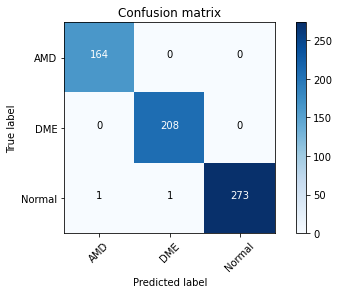

              precision    recall  f1-score   support

         AMD       0.99      1.00      1.00       164
         DME       1.00      1.00      1.00       208
      Normal       1.00      0.99      1.00       275

    accuracy                           1.00       647
   macro avg       1.00      1.00      1.00       647
weighted avg       1.00      1.00      1.00       647



In [13]:
# Predict model on Test Data

Y_pred = model.predict(X_test)
print(Y_pred)

# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

# Print the classes of the Prediction
y_pred = np.argmax(Y_pred,axis = 1) 
print(y_pred)

target_names = ['AMD', 'DME', 'Normal']
                                        
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Computation  confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=3)

plt.figure()

# Plotting non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
plt.show()


rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

print(classification_report(rounded_labels, y_pred, target_names=target_names))